In [2]:
# Read GPS data from source file
import pandas as pd

file_path = './PostData.xlsx'
gps_data = pd.read_excel(file_path)

#gps_data.drop(columns='date time', inplace=True)
gps_data['second'] = range(1, len(gps_data) + 1)
gps_data.insert(0, 'second', gps_data.pop('second'))

gps_data.head(10)

,second,gpsID,_date,speed,lat,lng,imei,vin,PelakNo,simcard
0,1,3,2024-11-12 00:00:00.000,99,36.08843,49.38452,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
1,2,3,2024-11-12 00:00:30.000,100,36.09209,49.37653,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
2,3,3,2024-11-12 00:01:00.000,100,36.09574,49.36853,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
3,4,3,2024-11-12 00:01:30.000,99,36.09950,49.36059,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
4,5,3,2024-11-12 00:02:00.000,99,36.10378,49.35303,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
5,6,3,2024-11-12 00:02:30.000,99,36.10849,49.34589,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
6,7,3,2024-11-12 00:03:00.000,99,36.11344,49.33859,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
7,8,3,2024-11-12 00:03:30.000,99,36.11821,49.33153,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
8,9,3,2024-11-12 00:04:00.000,99,36.12298,49.32450,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889
9,10,3,2024-11-12 00:04:30.000,99,36.12800,49.31773,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889


In [3]:
# Calculate distance
import pandas as pd
from geopy.distance import geodesic

# Shift the latitude and longitude columns to get the previous point's coordinates
gps_data['latitude_prev'] = gps_data['lat'].shift()
gps_data['longitude_prev'] = gps_data['lng'].shift()

# Define a function to calculate distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Apply the function row by row to calculate distance to the previous point
gps_data['distance'] = gps_data.apply(
    lambda row: calculate_distance(
        row['lat'], row['lng'],
        row['latitude_prev'], row['longitude_prev']
    ) if pd.notnull(row['latitude_prev']) and pd.notnull(row['longitude_prev']) else 0,
    axis=1
)
gps_data['cumulative_distance'] = gps_data['distance'].cumsum()

gps_data.drop(columns=['latitude_prev', 'longitude_prev'], inplace=True)

gps_data.head(10)

,second,gpsID,_date,speed,lat,lng,imei,vin,PelakNo,simcard,distance,cumulative_distance
0,1,3,2024-11-12 00:00:00.000,99,36.08843,49.38452,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,0.000000,0.000000
1,2,3,2024-11-12 00:00:30.000,100,36.09209,49.37653,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,826.277402,826.277402
2,3,3,2024-11-12 00:01:00.000,100,36.09574,49.36853,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,826.488592,1652.765994
3,4,3,2024-11-12 00:01:30.000,99,36.09950,49.36059,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,827.837398,2480.603391
4,5,3,2024-11-12 00:02:00.000,99,36.10378,49.35303,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,830.047292,3310.650683
5,6,3,2024-11-12 00:02:30.000,99,36.10849,49.34589,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,828.531812,4139.182495
6,7,3,2024-11-12 00:03:00.000,99,36.11344,49.33859,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,856.556759,4995.739254
7,8,3,2024-11-12 00:03:30.000,99,36.11821,49.33153,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,827.139362,5822.878616
8,9,3,2024-11-12 00:04:00.000,99,36.12298,49.32450,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,825.036506,6647.915123
9,10,3,2024-11-12 00:04:30.000,99,36.12800,49.31773,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,825.647918,7473.563041


In [7]:
import requests

def get_elevation(lat, lon):
    url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
    response = requests.get(url)
    if response.status_code == 200:
        elevation = response.json()['results'][0]['elevation']
        return elevation
    else:
        print("Error fetching data")
        return None

lat = gps_data['lat'].tolist()
lon = gps_data['lng'].tolist()


for i in range(100):
    elevation = get_elevation(lat[i], lon[i])
    gps_data.at[i, 'elevation'] = elevation

gps_data.head(200)

,second,gpsID,_date,speed,lat,lng,imei,vin,PelakNo,simcard,distance,cumulative_distance,elevation
0,1,3,2024-11-12 00:00:00.000,99,36.08843,49.38452,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,0.000000,0.000000,1492.0
1,2,3,2024-11-12 00:00:30.000,100,36.09209,49.37653,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,826.277402,826.277402,1502.0
2,3,3,2024-11-12 00:01:00.000,100,36.09574,49.36853,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,826.488592,1652.765994,1506.0
3,4,3,2024-11-12 00:01:30.000,99,36.09950,49.36059,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,827.837398,2480.603391,1514.0
4,5,3,2024-11-12 00:02:00.000,99,36.10378,49.35303,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,830.047292,3310.650683,1515.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,3,2024-11-12 00:47:07.000,66,36.52694,48.79978,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,617.665574,73168.164978,1796.0
96,97,3,2024-11-12 00:47:37.000,68,36.53032,48.79527,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,551.200420,73719.365397,1792.0
97,98,3,2024-11-12 00:48:07.000,69,36.53381,48.79066,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,566.063239,74285.428636,1791.0
98,99,3,2024-11-12 00:48:37.000,78,36.53766,48.78550,359857084384098,IRGC869z3HX027085,IRI@22الف758@11,9012468889,629.318344,74914.746980,1787.0


/tmp/ipykernel_10014/3976603083.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_data['elevation_diff'] = gps_data['elevation'].diff().fillna(0)
/tmp/ipykernel_10014/3976603083.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_data['distance_diff'] = gps_data['distance'].fillna(0)  # distance per segment
/tmp/ipykernel_10014/3976603083.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

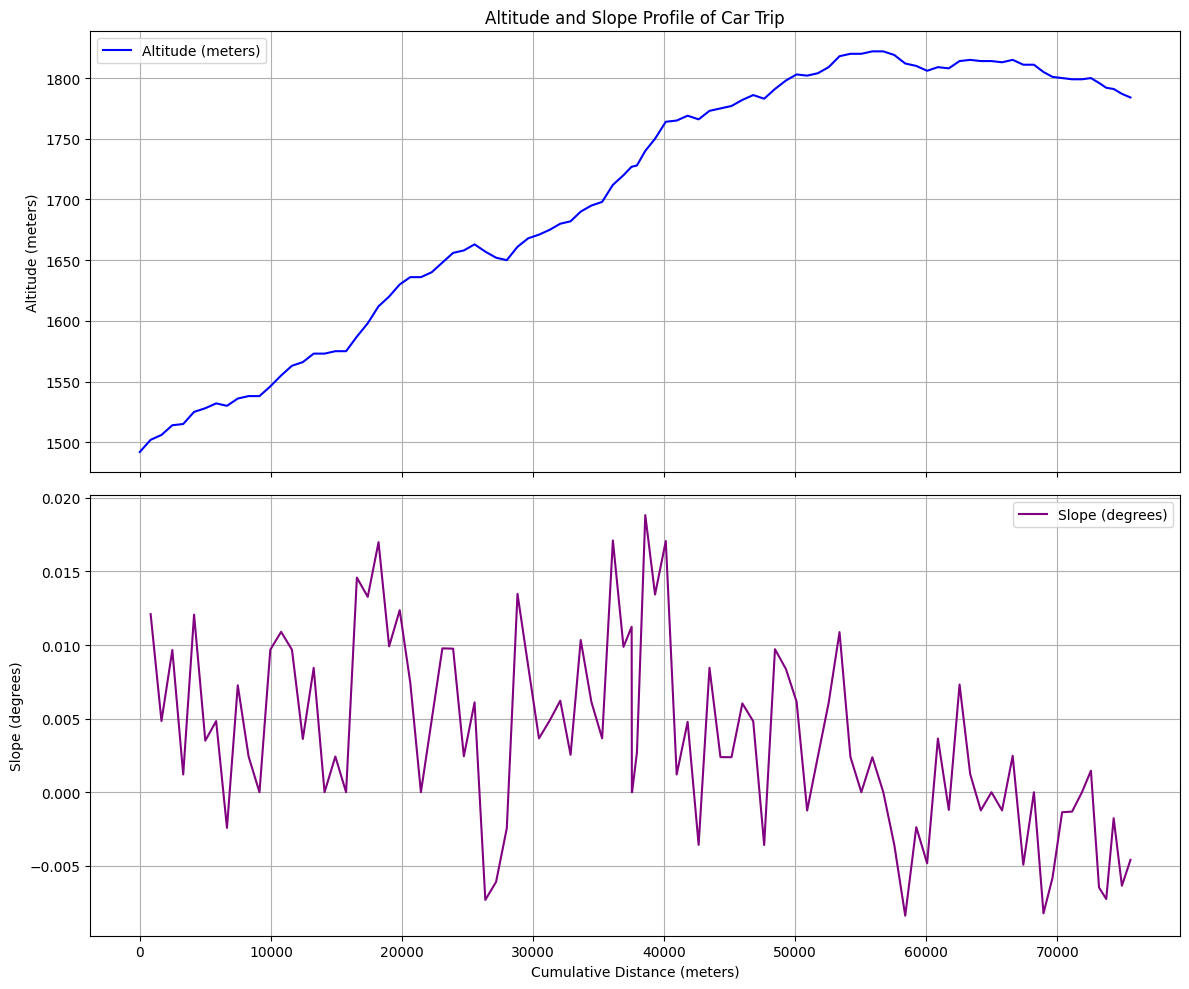

In [9]:
# Calculate energy demand
import numpy as np
import matplotlib.pyplot as plt

# Constants
mass_vehicle = 11380 + 5100  # total mass (curb + full load) in kg
frontal_area = 8.2  # m^2
drag_coefficient = 0.7  # drag coefficient
rolling_resistance_coefficient = 0.0041  # base coefficient for rolling resistance
air_density = 1.22  # kg/m^3
gravity = 9.81  # m/s^2
transmission_efficiency = 0.96  # transmission efficiency
differential_efficiency = 0.92  # differential efficiency
wheel_radius = 0.5  # approximate value for wheel radius in meters

# Calculate segment-wise forces and energy demand
# Part 1:
# Extract elevation from the GPS data
gps_data = gps_data.head(100)
#gps_data['elevation'] = gps_data['altitude(m)']  # using altitude for elevation data

# Calculate elevation difference to determine slope (grade angle)
gps_data['elevation_diff'] = gps_data['elevation'].diff().fillna(0)
gps_data['distance_diff'] = gps_data['distance'].fillna(0)  # distance per segment

# Calculate grade angle (theta) based on elevation difference
gps_data['slope'] = np.arctan(gps_data['elevation_diff'] / gps_data['distance_diff'])

# Plot altitude and slope on separate subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot altitude on the first subplot
ax1.plot(gps_data['cumulative_distance'], gps_data['elevation'], color='blue', label='Altitude (meters)')
ax1.set_ylabel('Altitude (meters)')
ax1.set_title('Altitude and Slope Profile of Car Trip')
ax1.grid(True)
ax1.legend()

# Plot slope on the second subplot
ax2.plot(gps_data['cumulative_distance'], gps_data['slope'], color='purple', label='Slope (degrees)')
ax2.set_xlabel('Cumulative Distance (meters)')
ax2.set_ylabel('Slope (degrees)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [11]:
#Apply forces
gps_data['drag_force'] = 0.5 * drag_coefficient *  air_density * frontal_area *  gps_data['speed']**2
gps_data['rolling_resistance'] = rolling_resistance_coefficient *  mass_vehicle *  gravity * np.cos(gps_data['slope'])
gps_data['grade_resistance'] = mass_vehicle * gravity * np.sin(gps_data['slope'])

# Calculate tractive force F_x for each segment
gps_data['tractive_force'] = (gps_data['drag_force'] + gps_data['rolling_resistance'] + gps_data['grade_resistance']) / (transmission_efficiency * differential_efficiency)

# Calculate energy demand (work done by tractive force over distance)
gps_data['energy_demand'] = gps_data['tractive_force'] * gps_data['distance_diff']  # in Joules

# Sum total energy demand across all segments
total_energy_demand = gps_data['energy_demand'].sum()  # in Joules
total_energy_demand_kWh = total_energy_demand / (3.6 * 1e6)  # convert to kWh

# Convert to hydrogen fuel requirement
hydrogen_energy_content_kWh_per_kg = 33  # kWh/kg for hydrogen
hydrogen_needed_kg = total_energy_demand_kWh / hydrogen_energy_content_kWh_per_kg

total_energy_demand_kWh, hydrogen_needed_kg

/tmp/ipykernel_10014/3015105238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_data['drag_force'] = 0.5 * drag_coefficient *  air_density * frontal_area *  gps_data['speed']**2
/tmp/ipykernel_10014/3015105238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_data['rolling_resistance'] = rolling_resistance_coefficient *  mass_vehicle *  gravity * np.cos(gps_data['slope'])
/tmp/ipykernel_10014/3015105238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

(np.float64(802.2146964296172), np.float64(24.309536255442946))